In [1]:
import numpy as np
import pandas as pd
import sklearn
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
data = pd.read_csv("recruitmentdataset-2022-1.3.csv")

In [3]:
D_data = data[(data['company'] == 'D') & (data['sport'].isin(['Swimming', 'Football', 'Golf']))]
D_data = D_data.drop(columns=['company','Id'])
D_data.info()
D_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 3000 to 3999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 474 non-null    object
 1   age                    474 non-null    int64 
 2   nationality            474 non-null    object
 3   sport                  474 non-null    object
 4   ind-university_grade   474 non-null    int64 
 5   ind-debateclub         474 non-null    bool  
 6   ind-programming_exp    474 non-null    bool  
 7   ind-international_exp  474 non-null    bool  
 8   ind-entrepeneur_exp    474 non-null    bool  
 9   ind-languages          474 non-null    int64 
 10  ind-exact_study        474 non-null    bool  
 11  ind-degree             474 non-null    object
 12  decision               474 non-null    bool  
dtypes: bool(6), int64(3), object(4)
memory usage: 32.4+ KB


,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,decision
3000,female,28,Dutch,Golf,65,False,False,True,False,1,False,phd,True
3001,female,22,Dutch,Football,70,False,True,False,False,1,True,master,True
3004,female,21,Dutch,Football,66,False,False,False,True,2,False,bachelor,True
3005,female,25,Dutch,Swimming,68,False,True,False,False,0,True,master,False
3006,male,31,Dutch,Football,67,False,True,False,False,2,True,master,True


# Data exploration

In [4]:
min_max_values = D_data.agg({
    'age': ['min', 'max'],
    'ind-university_grade': ['min', 'max'],
    'ind-languages': ['min', 'max']
})

min_max_values.rename(index={'min': 'Minimum', 'max': 'Maximum'}, inplace=True)
min_max_values.columns = ['Age', 'University Grade', 'Number of Languages']
min_max_values

,Age,University Grade,Number of Languages
Minimum,21,48,0
Maximum,32,78,3


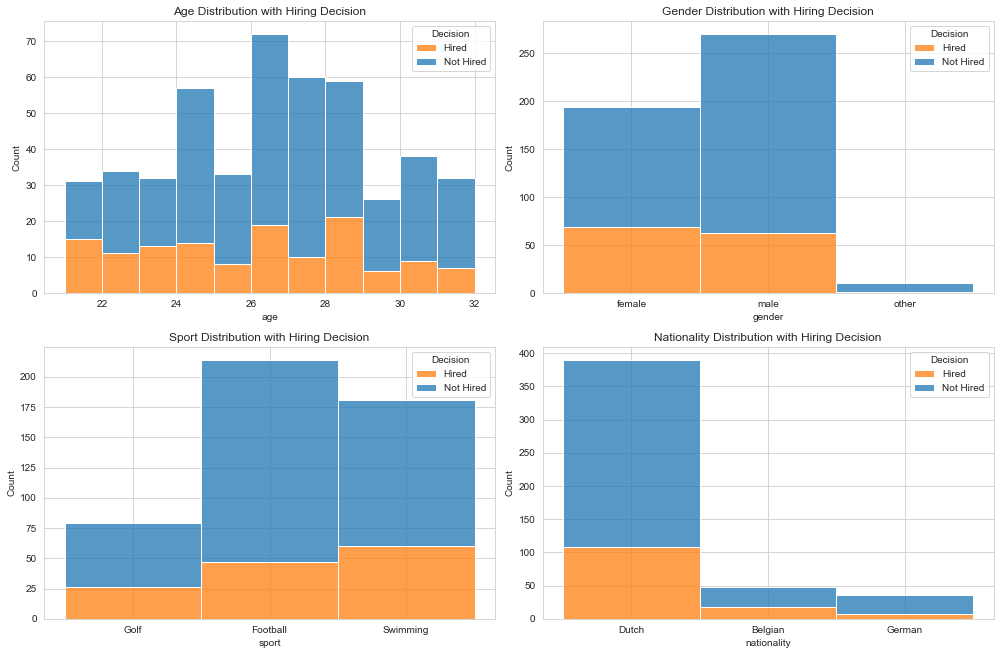

In [5]:
sns.set_style("whitegrid")


# Visualize data distributions and potential outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
sns.histplot(data=D_data, x='age', hue='decision', multiple="stack", ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution with Hiring Decision')
axes[0, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])
           
# gender distribution
sns.histplot(data=D_data, x='gender', hue='decision', multiple="stack", binwidth=1, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution with Hiring Decision')
axes[0, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])

# sport distribution
sns.histplot(data=D_data, x='sport',hue='decision', multiple="stack", bins=4, ax=axes[1, 0])
axes[1, 0].set_title('Sport Distribution with Hiring Decision')
axes[1, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])

# Nationality Distribution
sns.histplot(data=D_data, x='nationality', hue='decision', multiple="stack", ax=axes[1, 1])
axes[1, 1].set_title('Nationality Distribution with Hiring Decision')
axes[1, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

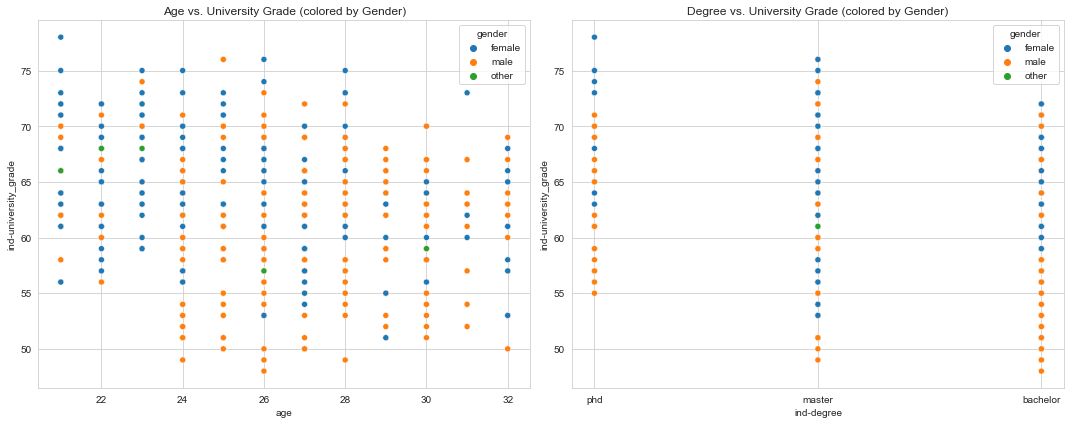

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=D_data, x='age', y='ind-university_grade', hue='gender', marker='o')
plt.title('Age vs. University Grade (colored by Gender)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=D_data, x='ind-degree', y='ind-university_grade', hue='gender', marker='o')
plt.title('Degree vs. University Grade (colored by Gender)')

plt.tight_layout()
plt.show()

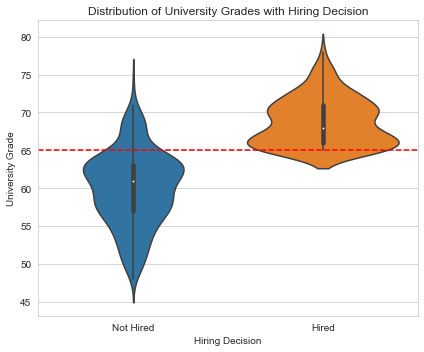

In [7]:
plt.figure(figsize=(6, 5))

sns.violinplot(data=D_data, x='decision', y='ind-university_grade')
plt.title('Distribution of University Grades with Hiring Decision')
plt.xlabel("Hiring Decision")
plt.ylabel("University Grade")
plt.xticks(ticks=[False, True], labels=['Not Hired', 'Hired'])
plt.axhline(y=65, color='r', linestyle='--', label='y=65')

plt.tight_layout()
plt.show()

- The median grade of hired candidates is visibly higher than that of non-hired candidates. The minimum grade requirement >=65 in relation to hiring decisions.

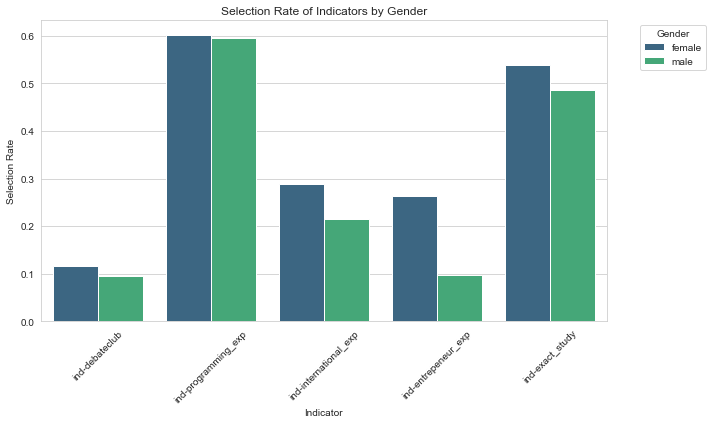

In [8]:
# Filter data for specified indicators and genders
filtered_data = D_data[D_data['gender'].isin(['female', 'male'])]

# Indicators of interest
indicators = [
    'ind-debateclub',
    'ind-programming_exp',
    'ind-international_exp',
    'ind-entrepeneur_exp',
    'ind-exact_study'
]

# Calculate selection rates for each indicator and gender
selection_rates_gender = pd.DataFrame()

for ind in indicators:
    rates = filtered_data[filtered_data[ind] == True].groupby('gender')['decision'].mean().reset_index()
    rates['indicator'] = ind
    selection_rates_gender = pd.concat([selection_rates_gender, rates], axis=0)

# Bar chart to visualize selection rates of indicators with gender
plt.figure(figsize=(10, 6))
sns.barplot(data=selection_rates_gender, x='indicator', y='decision', hue='gender', palette="viridis", ci=None)
plt.title('Selection Rate of Indicators by Gender')
plt.xlabel('Indicator')
plt.ylabel('Selection Rate')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
